# 1. Introduction

Airbnb was born in 2007 and has since grown to 4 million Hosts who have welcomed more than 1 billion guest arrivals in almost every country across the globe. Every day, Hosts offer unique stays that make it possible for guests to experience the world in a more authentic, connected way (https://news.airbnb.com/about-us/).

Munich is the capital and most populous city of the German state of Bavaria. With a population of about 1.56 Million inhabitants (in January 2022), it is the third-largest city in Germany, after Berlin and Hamburg, and thus the largest which does not constitute its own state, as well as the 11th-largest city in the European Union. The city's metropolitan region is home to 6 million people. Munich's numerous architectural and cultural attractions, sports events, exhibitions and its annual Oktoberfest attract considerable tourism (https://en.wikipedia.org/wiki/Munich).

In this notebook we will take a deeper look into the data of Airbnb listings in Munich. Key questions that will be answered are the following:
 1. Which are the popular neighbourhoods of Munich? 
 2. In which neighbourhood are most listings located? 
 3. Do listings in a popular neigbourhood get more reviews per month? 
 4. Which features influence how many review a listing will receive in a month?
 5. Can we predict the number of reviews per month with linear regression?

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

### Reading the Data

First of all, read the dataset of Airbnb listings in Munich, drop columns that will not be used in the following analysis, and look at the remaining variables:

In [2]:
df = pd.read_csv('listings.csv.gz', compression='gzip', header=0,    sep=',', quotechar='"', error_bad_lines=False)
df = df.drop(['listing_url','scrape_id','name','description','neighborhood_overview','picture_url','host_id', \
              'host_url','host_name','host_about','host_listings_count','host_thumbnail_url','host_picture_url','host_verifications','neighbourhood', \
               'host_neighbourhood','host_total_listings_count','neighbourhood_group_cleansed','latitude','longitude','bathrooms','maximum_nights','minimum_minimum_nights', \
                'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm', \
                'maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60','availability_90', \
                'last_review','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_value',\
                'calendar_last_scraped','number_of_reviews_ltm','license','calculated_host_listings_count_entire_homes', \
                'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','property_type',\
                'bathrooms_text','amenities','has_availability','number_of_reviews','number_of_reviews_l30d'], axis = 1)
pd.set_option('display.max_columns', None)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4995 non-null   int64  
 1   last_scraped                    4995 non-null   object 
 2   host_since                      4994 non-null   object 
 3   host_location                   4984 non-null   object 
 4   host_response_time              3129 non-null   object 
 5   host_response_rate              3129 non-null   object 
 6   host_acceptance_rate            3449 non-null   object 
 7   host_is_superhost               4994 non-null   object 
 8   host_has_profile_pic            4994 non-null   object 
 9   host_identity_verified          4994 non-null   object 
 10  neighbourhood_cleansed          4995 non-null   object 
 11  room_type                       4995 non-null   object 
 12  accommodates                    49

,id,last_scraped,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,minimum_nights,availability_365,first_review,review_scores_rating,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,reviews_per_month
0,97945,2021-12-24,2011-04-18,"Munich, Bayern, Germany",within a few hours,100%,NaN,t,t,t,Hadern,Entire home/apt,2,1.0,1.0,$80.00,2,22,2011-10-03,4.84,4.93,4.78,f,2,1.04
1,114695,2021-12-24,2011-05-12,"Munich, Bayern, Germany",within a few hours,100%,100%,f,t,t,Berg am Laim,Entire home/apt,5,1.0,3.0,$95.00,2,52,2011-07-08,4.77,5.00,4.55,f,2,0.42
2,127383,2021-12-24,2011-05-26,"Munich, Bayern, Germany",within a few hours,100%,83%,f,t,t,Maxvorstadt,Entire home/apt,4,1.0,1.0,$99.00,3,4,2011-06-04,4.86,4.96,4.91,f,1,0.79
3,159634,2021-12-24,2011-07-01,"Munich, Bavaria, Germany",within a day,100%,100%,f,t,t,Pasing-Obermenzing,Entire home/apt,2,1.0,1.0,$52.00,3,0,2011-08-15,4.63,4.75,4.50,f,1,0.27
4,170154,2021-12-24,2010-04-14,"Munich, Bayern, Germany",within a few hours,100%,97%,t,t,t,Sendling-Westpark,Private room,4,1.0,2.0,$55.00,2,162,2011-09-25,4.95,4.98,4.76,f,1,3.97


### Data Preparation for Data Exploratory Analysis

The columns ``host_since``,``last_scraped``, and ``first_review`` have to be transformed from objects to dates. Further, the days between ``host_since`` and ``last_scraped`` as well as ``first_review`` and ``last_scraped`` will be calculated to convert the dates to usable, numeric variables. 

Categorical variables will be converted either to dummy variables or to floats. For excample, we want to know if the host is a local or living somewhere else. Therefore the column ``host_location_munich`` is created, which is 1 if the column ``host_location`` contains 'Munich' and 0 otherwise. The column ``price`` is also listed as a categorical variable. Before the price to can be converted to a float the $-sign has to removed. For boolean objects, like ``host_is_superhost`` or ``instant_bookable`` the original values are 't' for 'true' and 'f' for 'false, but we want to replace them with 1 and 0 to make the columns usable in the regression analysis later on.

In [3]:
#Convert dates and calculate days between date and date of last scrape
for col in ['host_since','last_scraped','first_review']:
    df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d')
df['host_since_days'] = (df['last_scraped'] - df['host_since']).dt.days
df['first_review_days'] = (df['last_scraped'] - df['first_review']).dt.days

In [4]:
#Convert categorical variables

#categorical variables to dummies:
df['host_location_munich'] = np.where(df['host_location'].str.contains('Munich'), 1, 0)
df['host_response_within_hours'] = np.where(df['host_response_time'].str.contains('hour'), 1, 0)
df['room_type_entire'] = np.where(df['room_type'].str.contains('Entire'),1,0)

#categorical variables to floats:
df['price_flt'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_acceptance_rate_flt'] = df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)
df['host_response_rate_flt'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)

#boolean objects to float dummies:
df['host_is_superhost_flt'] = np.where(df['host_is_superhost'] == 't',1,0)
df['host_has_profile_pic_flt'] = np.where(df['host_has_profile_pic'] == 't',1,0)
df['host_identity_verified_flt'] = np.where(df['host_identity_verified'] == 't',1,0)
df['instant_bookable_flt'] = np.where(df['instant_bookable'] == 't',1,0)

In [5]:
#drop old variables
df = df.drop(['host_since','last_scraped','first_review','host_location','host_response_time',\
               'room_type','host_acceptance_rate','host_response_rate','price','host_is_superhost',\
               'host_has_profile_pic','host_identity_verified','instant_bookable'], axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4995 non-null   int64  
 1   neighbourhood_cleansed          4995 non-null   object 
 2   accommodates                    4995 non-null   int64  
 3   bedrooms                        4466 non-null   float64
 4   beds                            4856 non-null   float64
 5   minimum_nights                  4995 non-null   int64  
 6   availability_365                4995 non-null   int64  
 7   review_scores_rating            3812 non-null   float64
 8   review_scores_communication     3762 non-null   float64
 9   review_scores_location          3762 non-null   float64
 10  calculated_host_listings_count  4995 non-null   int64  
 11  reviews_per_month               3812 non-null   float64
 12  host_since_days                 49

Above table shows that all columns were converted to numeric variables, with the exception of ``neighbourhood_cleansed``, which is needed in its original type to answer the first three business questions. Also, we see that there are missing data for some features, which will be detailed later.

# 2. Data Exploratory Analysis

### Data Understanding

In this chapter, we will answer the first three business questions:
1. Which are the popular neighbourhoods of Munich?
2. In which neighbourhood are most listings located?
3. Do listings in a popular neigbourhood get more reviews per month?

But first, let's define which neighbourhoods belong to the city center of Munich:

In [7]:
# Does the Neighbourhood belong to the city center of Munich?
list_centrum = ['Altstadt-Lehel', 'Au-Haidhausen', 'Ludwigsvorstadt-Isarvorstadt','Maxvorstadt',\
                'Neuhausen-Nymphenburg','Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe','Sendling' ]

df['nbh_center'] = np.where(df['neighbourhood_cleansed'].isin(list_centrum),1,0)
df.head()

,id,neighbourhood_cleansed,accommodates,bedrooms,beds,minimum_nights,availability_365,review_scores_rating,review_scores_communication,review_scores_location,calculated_host_listings_count,reviews_per_month,host_since_days,first_review_days,host_location_munich,host_response_within_hours,room_type_entire,price_flt,host_acceptance_rate_flt,host_response_rate_flt,host_is_superhost_flt,host_has_profile_pic_flt,host_identity_verified_flt,instant_bookable_flt,nbh_center
0,97945,Hadern,2,1.0,1.0,2,22,4.84,4.93,4.78,2,1.04,3903.0,3735.0,1,1,1,80.0,NaN,100.0,1,1,1,0,0
1,114695,Berg am Laim,5,1.0,3.0,2,52,4.77,5.00,4.55,2,0.42,3879.0,3822.0,1,1,1,95.0,100.0,100.0,0,1,1,0,0
2,127383,Maxvorstadt,4,1.0,1.0,3,4,4.86,4.96,4.91,1,0.79,3865.0,3856.0,1,1,1,99.0,83.0,100.0,0,1,1,0,1
3,159634,Pasing-Obermenzing,2,1.0,1.0,3,0,4.63,4.75,4.50,1,0.27,3829.0,3784.0,1,0,1,52.0,100.0,100.0,0,1,1,0,0
4,170154,Sendling-Westpark,4,1.0,2.0,2,162,4.95,4.98,4.76,1,3.97,4272.0,3743.0,1,1,0,55.0,97.0,100.0,1,1,1,0,0


Now that we have defined which neighbourhood belongs to the city center, we can calculate the minimum, maximum, and median-values of ``review_scores_location`` and ``reviews_per_month`` for each ``neighbourhood_cleansed``.

In [8]:
#Group by Neighbourhood and aggregate review_scores_location and reviews_per_month
df_loc = df[df['review_scores_location'].isnull()==0] \
        .groupby(['neighbourhood_cleansed','nbh_center']) \
        .aggregate({'review_scores_location': ['min', 'max', 'median'], \
                    'reviews_per_month':['min', 'max', 'median' ,'count']}) \
        .reset_index()
#rename columns
df_loc.columns = ['neighbourhood_cleansed','center','min_rating_loc', 'max_rating_loc','median_rating_loc', \
                 'min_reviews_per_month', 'max_reviews_per_month','median_reviews_per_month','count_listings']

df_loc

,neighbourhood_cleansed,center,min_rating_loc,max_rating_loc,median_rating_loc,min_reviews_per_month,max_reviews_per_month,median_reviews_per_month,count_listings
0,Allach-Untermenzing,0,2.50,5.0,4.670,0.03,3.27,0.36,31
1,Altstadt-Lehel,1,4.00,5.0,5.000,0.02,5.50,0.45,128
2,Au-Haidhausen,1,3.00,5.0,4.960,0.01,5.78,0.34,254
3,Aubing-Lochhausen-Langwied,0,3.00,5.0,4.750,0.03,6.16,0.44,40
4,Berg am Laim,0,3.92,5.0,4.750,0.03,3.30,0.27,77
5,Bogenhausen,0,3.00,5.0,4.820,0.01,4.94,0.39,181
6,Feldmoching-Hasenbergl,0,3.50,5.0,4.665,0.02,5.56,0.27,54
7,Hadern,0,4.00,5.0,4.800,0.02,1.78,0.44,33
8,Laim,0,2.00,5.0,4.800,0.02,3.25,0.26,106
9,Ludwigsvorstadt-Isarvorstadt,1,3.00,5.0,4.940,0.01,55.33,0.39,467


#### 1. Which are the popular neighbourhoods of Munich?
The chart below shows, that listings located in the city center of Munich get higher ratings for location than listings located outsinde the city center. With a median rating of 5 out of 5 points the neighbourhood 'Altstadt-Lehel' is the most popular location in Munich, followed by 'Maxvorstadt' and 'Au-Haidhausen'. This is not surprising, since 'Altstadt-Lehel' covers the historical area of Munich as well as the north east of the city center, where the river 'Isar', the English Garden, and the poplular shopping street 'Prinzregentenstraße' are located.

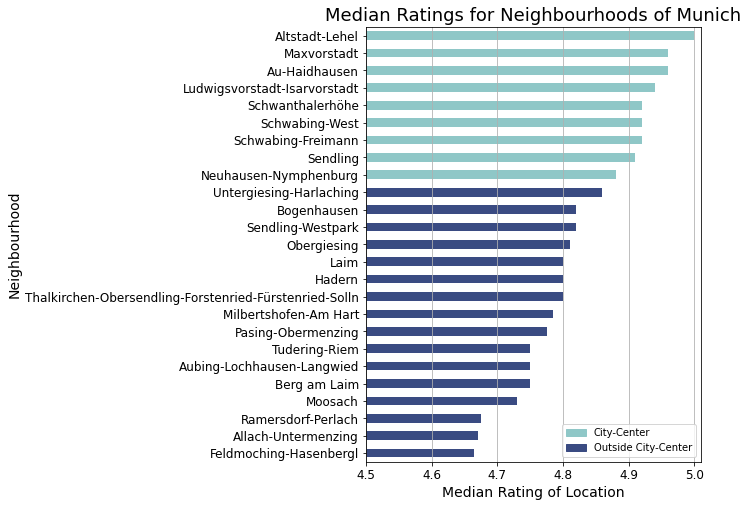

In [9]:
df_loc.sort_values('median_rating_loc',inplace=True)
colors = {1: '#8FC7C7', 0: '#3A4B82'}
df_loc.plot(kind='barh',y='median_rating_loc' ,x='neighbourhood_cleansed',\
            legend= False, figsize=(6,8),fontsize=12,xlim=(4.5, 5.01),\
            color=[colors[i] for i in df_loc['center']]\
           )
plt.title('Median Ratings for Neighbourhoods of Munich', fontsize=18)
plt.xlabel('Median Rating of Location', fontsize=14)
plt.ylabel('Neighbourhood', fontsize=14)

CC = mpatches.Patch(color='#8FC7C7', label='City-Center')
NC = mpatches.Patch(color='#3A4B82', label='Outside City-Center')
plt.legend(handles=[CC,NC], loc=4)

plt.grid(True, axis='x')

#### 2. In which neighbourhood are most listings located?
Neigbourhoods belonging to the city center of Munich in general have more Airbnb listings than neighourhoods outside the city center. However, the cut is not quite as clear as in the chart before. Also, we can not assume, that popular locations generally have more listings. The top rated neighourhood 'Altstadt-Lehel' for excample, is only ranked as number 13 out of all 24 neighbourhoods. Most listings are located in 'Ludwigsvorstadt-Isarvorstadt' which was the fourth best rated neighbourhood in the chart before. 'Ludwigsvorstadt-Isarvorstadt' is boardering 'Altstadt-Lehel' in the south-west and lies in close vicinity to the main train station and the 'Theresienwiese' where the Oktoberfest is located once a year.

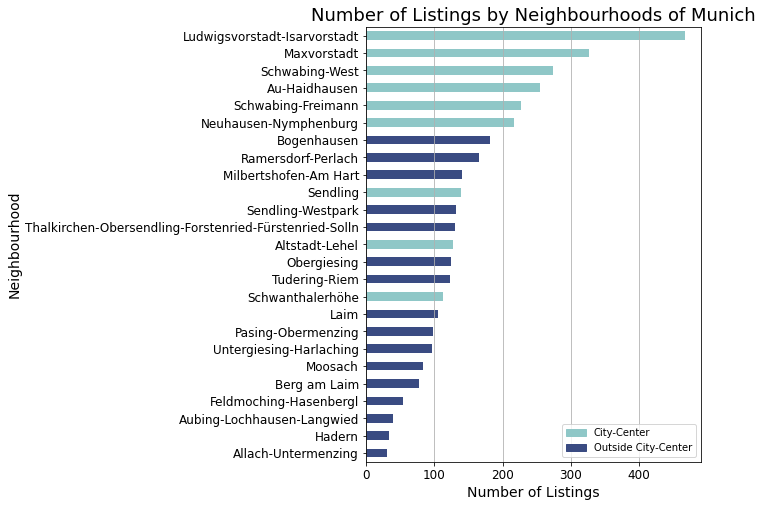

In [10]:
df_loc.sort_values('count_listings',inplace=True)
colors = {1: '#8FC7C7', 0: '#3A4B82'}
df_loc.plot(kind='barh',y='count_listings' ,x='neighbourhood_cleansed',\
            legend= False, figsize=(6,8),fontsize=12,\
            color=[colors[i] for i in df_loc['center']]\
           )
plt.title('Number of Listings by Neighbourhoods of Munich', fontsize=18)
plt.xlabel('Number of Listings', fontsize=14)
plt.ylabel('Neighbourhood', fontsize=14)
CC = mpatches.Patch(color='#8FC7C7', label='City-Center')
NC = mpatches.Patch(color='#3A4B82', label='Outside City-Center')
plt.legend(handles=[CC,NC], loc=4)
plt.grid(True, axis='x')

#### 3. Do listings in a popular neigbourhood get more reviews per month?
The chart below shows, that there is no obvious connection between the popularity of a neighbourhood and the number of ratings a listing in this neighbourhood receives. For excample, listings located in the neighbourhoods 'Ramersdorf-Perlach' and 'Trudering-Riem' outside the city center, generally get more reviews per month than listings located in the popular neighbourhoogs 'Altstadt-Lehel' and 'Ludwigsvorstadt-Isarvorstadt'. 'Ramersdorf-Perlach' was the third lowest rated neighbourhood in Munich, but it was among the top 10 locations with the most listings.

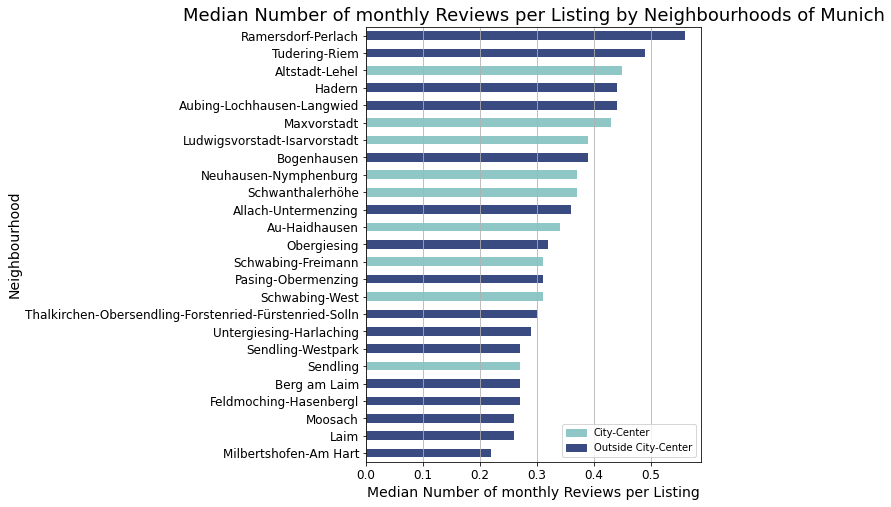

In [11]:
df_loc.sort_values('median_reviews_per_month',inplace=True)
colors = {1: '#8FC7C7', 0: '#3A4B82'}
df_loc.plot(kind='barh',y='median_reviews_per_month' ,x='neighbourhood_cleansed',\
            legend= False, figsize=(6,8),fontsize=12,\
            color=[colors[i] for i in df_loc['center']]\
           )
plt.title('Median Number of monthly Reviews per Listing by Neighbourhoods of Munich', fontsize=18)
plt.xlabel('Median Number of monthly Reviews per Listing', fontsize=14)
plt.ylabel('Neighbourhood', fontsize=14)
CC = mpatches.Patch(color='#8FC7C7', label='City-Center')
NC = mpatches.Patch(color='#3A4B82', label='Outside City-Center')
plt.legend(handles=[CC,NC], loc=4)
plt.grid(True, axis='x')

### Further Data Preparation for Regression Modeling
After answering the first tree business questions, we continue with the data preparation to match the prerequisites of linear regression.

#### Categorical Variable ``Neighbourhood_cleansed``
The last remaining categorical variable of the dataset ``Neighbourhood_cleansed`` will be replaced with ``median_rating_loc`` and ``count_listings``. This way, we keep more information about the neighbourhood in the dataset, than if the neighbourhood was just dummy coded.

In [12]:
#Prepare relevant columnns for merge
df_g = df_loc[['neighbourhood_cleansed','median_rating_loc','count_listings']]
df_g = df_g.sort_values(by='neighbourhood_cleansed')
df_g.columns = ['neighbourhood_cleansed', 'nbh_med_rating','nbh_cnt_listings']

#Merge average rating for location and averager number of ratings per listing on neighbourhood_cleansed
df_m = pd.DataFrame()
if not 'nbh_med_reviews_per_month' in df_m.columns:
    df_m = pd.merge(df, df_g, on = 'neighbourhood_cleansed', how = 'left')
    print('Merge completed')

Merge completed


In [13]:
#drop neighbourhood_cleansed 
df_m = df_m.drop('neighbourhood_cleansed', axis = 1)

#### Handling Missing Values
Earlier, we saw that some features had missing data. However, the prerequisites of linear regression don't allow missing values. Therefore, we have two options how to deal with missing values: 
1. Rows with missing values can be eliminated.
2. Missing values can be replaced with 0 or the column's average.

In the linear regression model, we want to predict how many reviews per month a listing is going to receive. Since ``reviews_per_month`` is the dependent variable, we don't want to make any wrong assumptions by replacing the missing values with 0 or the column's average. Rows with missing values in the column ``reviews_per_month`` will therefore be excluded. Missing values in other columns will be replaced with the average.

In [14]:
df_m = df_m[df_m['reviews_per_month'].notna()].reset_index(drop=True)
print(np.sum(df_m.isna()))

id                                   0
accommodates                         0
bedrooms                           406
beds                                70
minimum_nights                       0
availability_365                     0
review_scores_rating                 0
review_scores_communication         50
review_scores_location              50
calculated_host_listings_count       0
reviews_per_month                    0
host_since_days                      0
first_review_days                    0
host_location_munich                 0
host_response_within_hours           0
room_type_entire                     0
price_flt                            0
host_acceptance_rate_flt           981
host_response_rate_flt            1286
host_is_superhost_flt                0
host_has_profile_pic_flt             0
host_identity_verified_flt           0
instant_bookable_flt                 0
nbh_center                           0
nbh_med_rating                       0
nbh_cnt_listings         

In [15]:
# Fill numeric columns with the mean
num_vars = df_m.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df_m[col].fillna((df_m[col].mean()), inplace=True)
        
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3812 entries, 0 to 3811
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3812 non-null   int64  
 1   accommodates                    3812 non-null   int64  
 2   bedrooms                        3812 non-null   float64
 3   beds                            3812 non-null   float64
 4   minimum_nights                  3812 non-null   int64  
 5   availability_365                3812 non-null   int64  
 6   review_scores_rating            3812 non-null   float64
 7   review_scores_communication     3812 non-null   float64
 8   review_scores_location          3812 non-null   float64
 9   calculated_host_listings_count  3812 non-null   int64  
 10  reviews_per_month               3812 non-null   float64
 11  host_since_days                 3812 non-null   float64
 12  first_review_days               38

#### Distribution of Variables
After handling the missing values in the dataset, it is time to look at the destribution of some selecet features. Special focus will be payed to the dependent variable ``reviews_per_month`` as well as the other features with conspicious distributions.

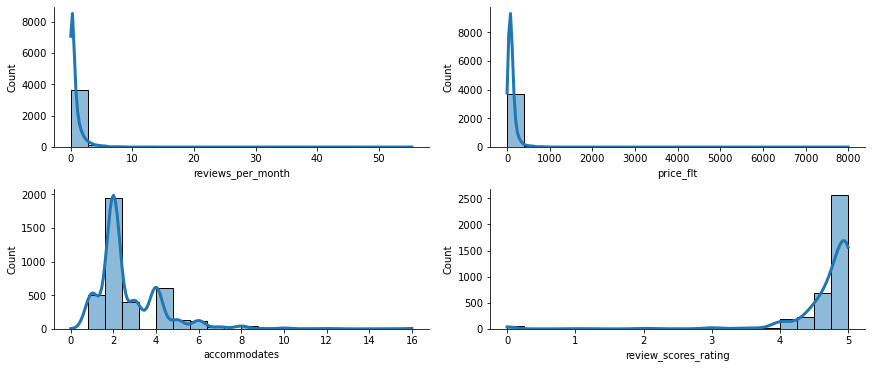

In [16]:
df_dist = df_m[['reviews_per_month','price_flt','accommodates','review_scores_rating']]
column_list = list(df_dist.columns)

fig, ax = plt.subplots(2,2, figsize=(12,5), constrained_layout=True)
axes_list = [axes for axes_row in ax for axes in axes_row]

for i, col_name in enumerate(column_list):
    sb.histplot(data=df_dist, x=col_name, ax=axes_list[i], bins=20, kde=True, line_kws={'linewidth':3})

# remove axes line on top-right
sb.despine()
plt.show()

The above distribution graph shows that there is a right-skewed distribution on ``reviews_per_month`` and ``price_flt`` as well as a left-skewed distribution on ``review_scores_rating``. The package skew_autotransform (https://datamadness.github.io/Skewness_Auto_Transform) uses Box-Cox transformation by default and will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis.


 ------------------------------------------------------

 'reviews_per_month' had 'positive' skewness of 15.25

 Transformation yielded skewness of -0.00


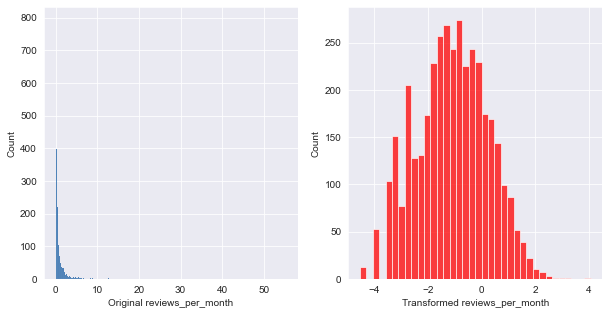


 ------------------------------------------------------

 'price_flt' had 'positive' skewness of 23.72

 Transformation yielded skewness of -0.06


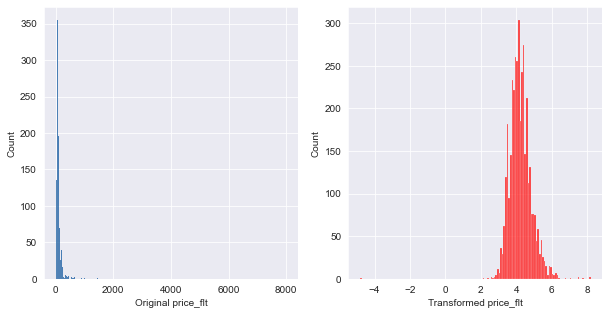


 ------------------------------------------------------

 'review_scores_rating' had 'negative' skewness of -5.22

 Transformation yielded skewness of -1.65


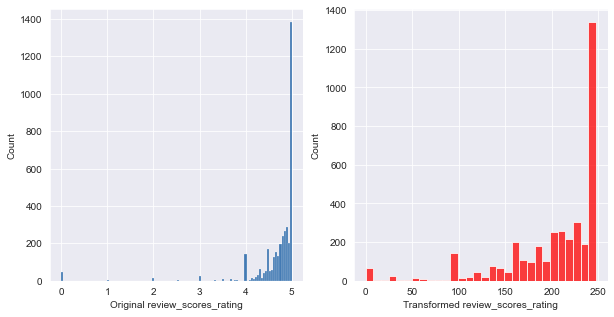


 ------------------------------------------------------

 'accommodates' had 'positive' skewness of 2.58

 Transformation yielded skewness of -0.00


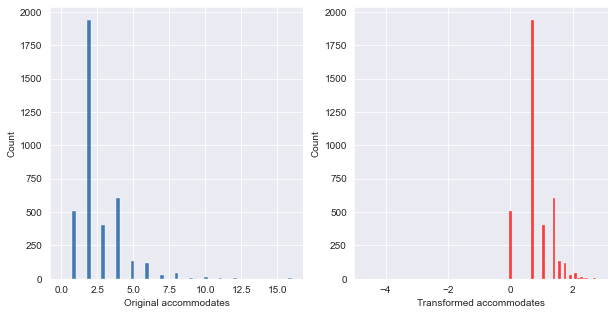


 ------------------------------------------------------

 'minimum_nights' had 'positive' skewness of 17.94

 Transformation yielded skewness of 0.20


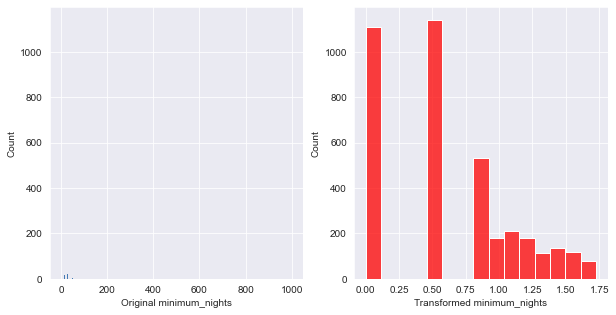

Original average skewness value was 5.10
Average skewness after transformation is 2.68


In [17]:
from skew_autotransform import skew_autotransform

exampleDF = df_m

transformedDF = skew_autotransform(exampleDF.copy(deep=True), plot = True, exp = False, threshold = 1,\
                                   include = ['reviews_per_month','price_flt','review_scores_rating','accommodates',\
                                              'minimum_nights'])

print('Original average skewness value was %2.2f' %(np.mean(abs(exampleDF.skew()))))
print('Average skewness after transformation is %2.2f' %(np.mean(abs(transformedDF.skew()))))

In [18]:
transformedDF.describe()

,id,accommodates,bedrooms,beds,minimum_nights,availability_365,review_scores_rating,review_scores_communication,review_scores_location,calculated_host_listings_count,reviews_per_month,host_since_days,first_review_days,host_location_munich,host_response_within_hours,room_type_entire,price_flt,host_acceptance_rate_flt,host_response_rate_flt,host_is_superhost_flt,host_has_profile_pic_flt,host_identity_verified_flt,instant_bookable_flt,nbh_center,nbh_med_rating,nbh_cnt_listings
count,3.812000e+03,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.000000,3812.00000,3812.000000,3812.000000,3812.00000
mean,2.854819e+07,0.860457,1.253376,1.684393,0.621393,128.162644,202.713436,4.855253,4.787403,2.417366,-1.091641,2060.059286,1182.432581,0.731899,0.788562,0.606506,4.232223,70.241611,88.541964,0.203043,0.995016,0.849948,0.26128,0.569255,4.866077,214.00341
std,1.560559e+07,0.510856,0.948744,1.456107,0.487598,133.063056,54.737806,0.340399,0.327221,4.222150,1.322133,944.672042,849.717818,0.443028,0.408382,0.488589,0.611689,29.715368,20.407776,0.402317,0.070432,0.357170,0.43939,0.495245,0.089633,120.73056
min,9.794500e+04,-4.644628,1.000000,1.000000,0.000000,0.000000,-0.230906,1.000000,1.000000,1.000000,-4.534721,14.000000,1.000000,0.000000,0.000000,0.000000,-4.832080,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.665000,31.00000
25%,1.610526e+07,0.697234,1.000000,1.000000,0.000000,0.000000,180.927372,4.850000,4.710000,1.000000,-2.026314,1244.000000,553.000000,0.000000,1.000000,0.000000,3.845615,63.000000,88.541964,0.000000,1.000000,1.000000,0.00000,0.000000,4.800000,125.00000
50%,3.022921e+07,0.697234,1.000000,1.000000,0.573073,86.000000,219.030516,4.990000,4.880000,1.000000,-1.074913,2128.000000,988.000000,1.000000,1.000000,1.000000,4.189060,70.241611,90.000000,0.000000,1.000000,1.000000,0.00000,1.000000,4.910000,181.00000
75%,4.071671e+07,1.385229,1.253376,2.000000,0.959785,252.250000,247.664571,5.000000,5.000000,2.000000,-0.127779,2773.250000,1622.000000,1.000000,1.000000,1.000000,4.557737,98.000000,100.000000,0.000000,1.000000,1.000000,1.00000,1.000000,4.940000,274.00000
max,5.384481e+07,2.759034,27.000000,30.000000,1.727266,365.000000,247.664571,5.000000,5.000000,33.000000,4.067861,4628.000000,3856.000000,1.000000,1.000000,1.000000,8.199904,100.000000,100.000000,1.000000,1.000000,1.000000,1.00000,1.000000,5.000000,467.00000


Next step is to grop columns that should not be used for the regression.

#### Creating a Correlation Matrix
Now it is time to get more details about the data. A correlation table will be created and the Pearson method will be used.

Text(0.5, 1.0, 'Correlation Matrix')

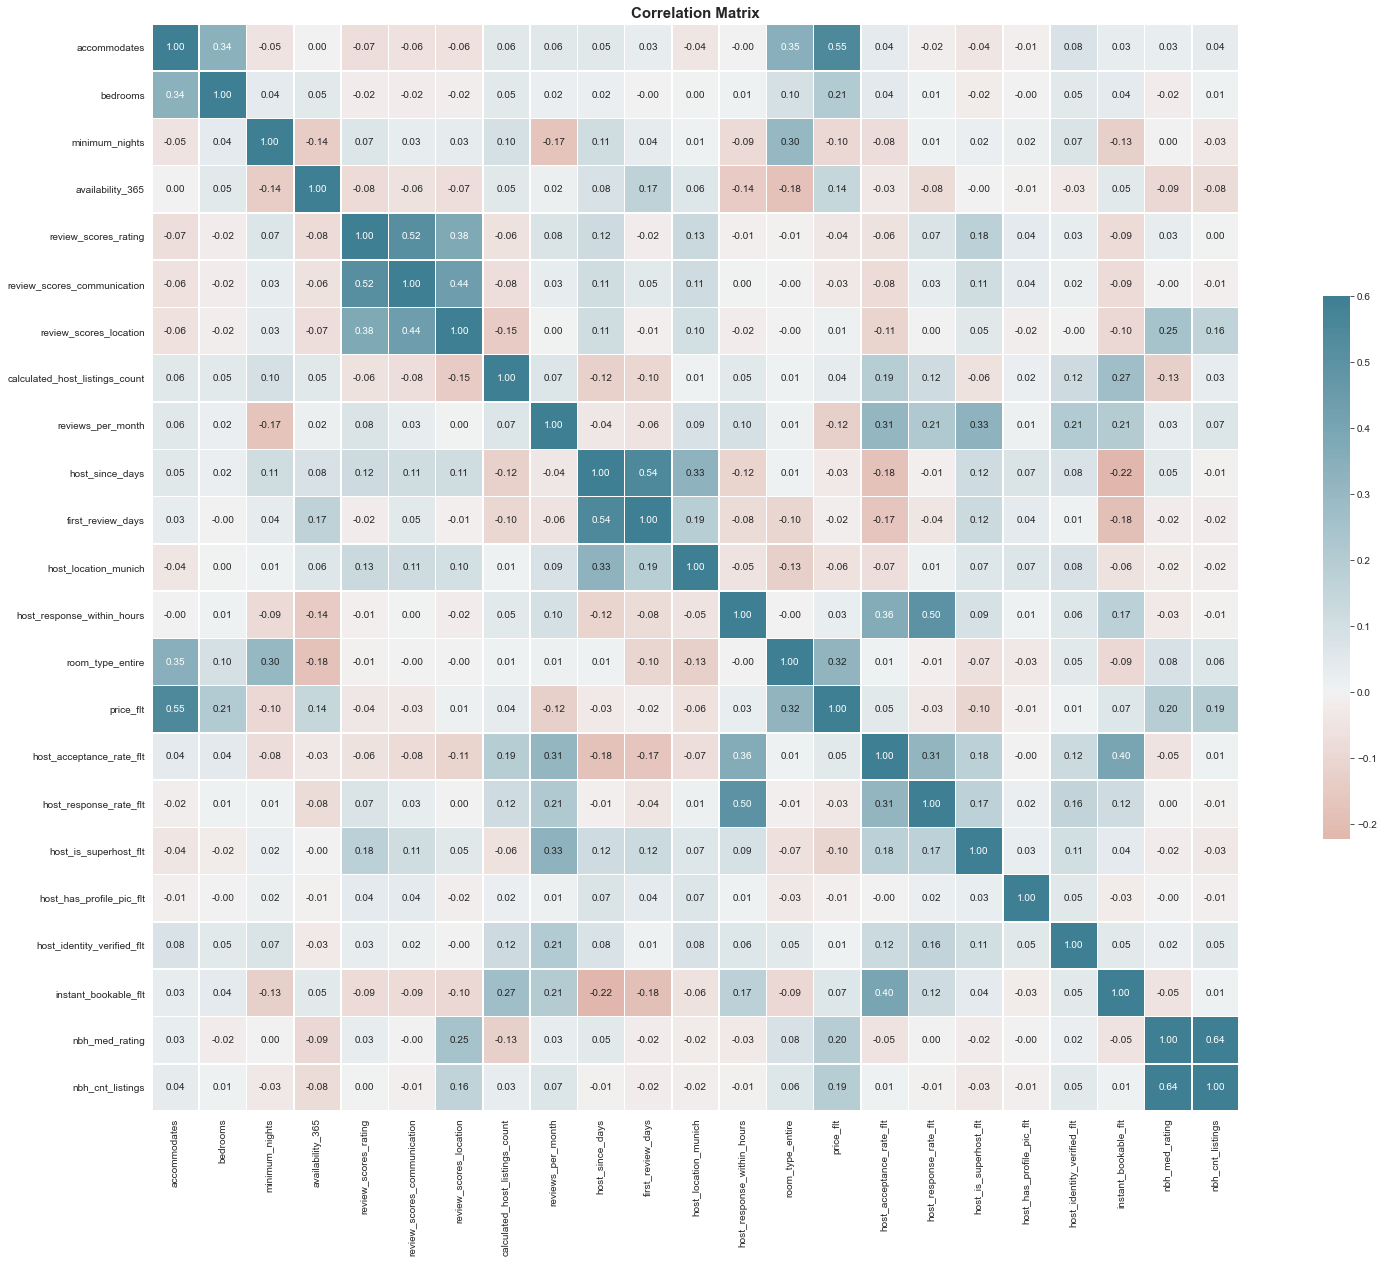

In [19]:
#drop columns that should not be used in the regression model
df_model = transformedDF.drop(['id','beds','nbh_center'], axis = 1)
#calculate correlation matrix
plt.figure(figsize=(30,20))
palette = sb.diverging_palette(20, 220, n=256)
corr=df_model.corr(method='pearson')
sb.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(23, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

The correlation table shows that there is no strong relationship between pthe number of reviews per month and other features. This indicates no feature needed to be taken out of data. This relationship will be detailed with Multicollinearity.

#### Handling Outliers
Box Plot is strong method to detect outliers. The below charts marks outliers with 'o' and strong outliers with '*'.

[]

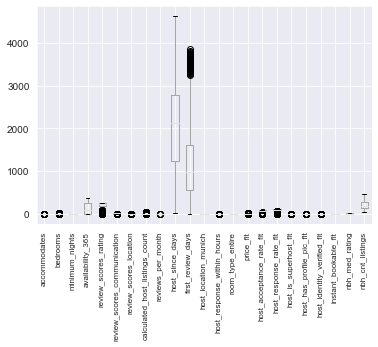

In [20]:
#check for outliers
df_model.boxplot(return_type='dict') 
plt.tick_params(axis='x', labelrotation = 90, labelsize = 8)
plt.plot()

There are no strong outliers in the dataset. Data normalization will be selected for the regression model.

#### Test for Multicollinearity

Multicollinearity will help to measure the relationship between explanatory variables in multiple regression. If there is multicollinearity occurs, these highly related input variables should be eliminated from the model.

In this kernel, multicollinearity will be control with ``Eigen vector values`` results. 

In [21]:
#Eigen vector of a correlation matrix.
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([2.59214015, 2.23255593, 2.12222856, 1.77276521, 1.53369325,
       1.36545282, 1.18948231, 1.09399408, 0.9877836 , 0.89439658,
       0.84836709, 0.83053414, 0.30990115, 0.32867576, 0.7321497 ,
       0.69989038, 0.38323493, 0.63949888, 0.4195111 , 0.44288117,
       0.55891671, 0.49745662, 0.5244899 ])

None one of the eigenvalues of the correlation matrix is close to zero. It means that there is no multicollinearity exists in the data.

# 3. Prediction with Linear Regression Model

Questions number 4 and 5 will be answeres with a Linear Regresseion Model to predict the number of reviews for the listings in Munich:

4. Which features influence how many review a listing will receive in a month?
5. Can we predict the number of reviews per month with linear regression?

#### Building the Linear Regression Model

In [22]:
#Define X and y
X = df_model.drop(['reviews_per_month'], axis=1)
y = df_model['reviews_per_month']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
    
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.3183688157190566.  The rsquared on the test data was 0.3115373857631064.


R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. R-squared measures the strength of the relationship between the model and the dependent variable on a 0 – 100% scale (https://statisticsbyjim.com/regression/interpret-r-squared-regression/).

In the training data 32% of the variance in the dependent variable ``reviews_per_month`` are explained by the independent variables in the model. In the testing data 31% are explained. Fist of all, it is a good sign that the R-squared of the training and testing data are very similar, indicating a robust result. However, 30% of explained variance indicates that there are important factors influencing  the ``reviews_per_month``, which are not included in the model. Those factors might include the  pictures' quality, the description of the listing, the number of actual bookings per month, but also factors of human behaviour and the guests' personalities.

#### 4. Which features influence how many review a listing will receive in a month?
To visualise, which factor has the highest influence on how many reviews a listing will get in a month, we build a ``feature importance`` graph. For this ``Extra Trees Classifier`` method will be used.

The results rank ``first_review_days``, ``price_flt``, ``host_since_days``, ``review_scores_rating``, and ``availability_365`` to have the highest influence on how many reviews a listing will receive in a month. Wheather the host as a profile picture or is superhost has a relatively low impact on the received number of reviews. 

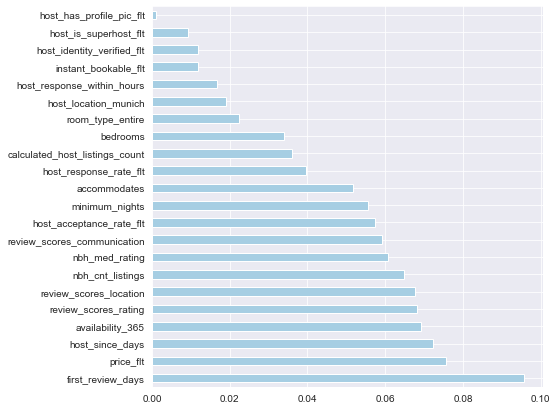

In [23]:
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,lab_enc.fit_transform(y_train))

plt.figure(figsize=(7,7))
feat_importances = pd.Series(feature_model.feature_importances_, index=df_model.drop(['reviews_per_month'], axis=1).columns)
feat_importances.nlargest(22).plot(kind='barh')
plt.show()

#### Should the features with low impact be excluded from the model? 
To visualise how the R-squared would change with less features, the function ``find_optimal_lm_mod`` from the Udacity online tutorial will be used: 

In [24]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test



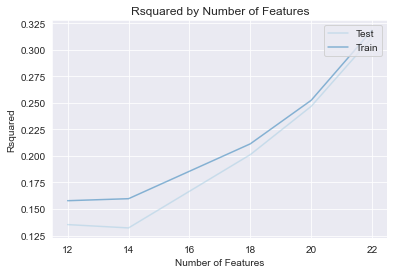

In [25]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25, 15, 10 ,5]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

The graph shows that the R-squared continues to grow with each added feature. Excluding features from the model, even if they seem to have a low explanatory value, would result in an even lower R-squared and is therefore not recommended.

#### 5. Can we predict the number of reviews per month with linear regression?
The following scatterplot visualises the values the linear regression model predicted for the test dataset on the y-axis and plots the actual values on the x-axis. In general the predicted values are higher when the actual test values are also high and the predicted values are lower when the test values are lower. However, as the R-squared of 31% is implicating, the model only explain less than half of the variance in the dependent variable. It is a very rough approach to predict the number of review a listing will get per month, but important features such as the number of actual bookings per month, but also factors of human behaviour and the guests' personalities are not included in the model.

Text(0, 0.5, 'Predictions')

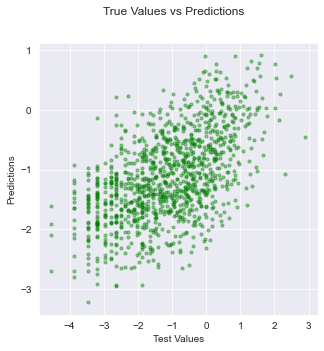

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_preds, s=10, color="green", alpha=0.4)
plt.suptitle('True Values vs Predictions')
plt.xlabel('Test Values')
plt.ylabel('Predictions')


# 5. Conclusion

In this kernel, I analysed the Airbnb Dataset for listings in Munich. Exploratory analyses discovered the most popular neighbourhoods of Munich as well as the ones with the most listings. We found that listings in poplular neighbourhoods do not neccessarily get more ratings per month. The linear regression model showed the most important features for the perdiction of review per month, where the listing's price, its overall rating and its availability are among the top 5. However, the features in the model only explained 31% of the variance in the number of reviews a listing gets per month. Features such as the number of actual bookings per month and factors of human behaviour and the guests' personalities are not included in the model, but might be helpful for a more accurate prediction.